In [2]:
import math
import ast
import statistics
import numpy as np
import os
import csv
import json
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as nd
import pickle as pkl
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Main data parsing functions

In [3]:
def save_plot_data(obj, name, path):
    with open(path+name+'.pkl', 'wb') as f:
        pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

def load_plot_data(name, path):
    with open(path+name+'.pkl', 'rb') as f:
        return pkl.load(f)

def load_json_data(inputfile):
    summ_data = []
    
    with open(inputfile) as json_file:
        summ_data = json.load(json_file)
        print('agent_ID: ' + summ_data['agent_ID'])
        #print('agent_type: ' + summ_data['agent_type'])
        #print('total_episodes: ' + str(summ_data['total_episodes']))
        #print('total_reward: ' + str(summ_data['total_reward']))
        #print('avg_rec_err: ' + str(summ_data['avg_rec_err']))
        #print('CL_ratio: ' + str(summ_data['CL_ratio']))
        #print('STM_length: ' + str(summ_data['STM_length']))
        #print('rec_thres: ' + str(summ_data['rec_thres']))
        #print('mean_step_rew: ' + str(summ_data['mean_step_rew']))
        #print('mean_step_log: ' + data['mean_step_log'])
        #print('wins_reactive: ' + str(summ_data['wins_reactive']))
        #print('wins_contextual: ' + str(summ_data['wins_contextual']))
        #print('auto_reliable: ' + str(summ_data['auto_reliable']))

    return summ_data

def load_csv_data(inputfile):

    # initializing the titles and rows list 
    fields = [] 
    data = [] 

    # reading csv file 
    with open(inputfile, 'r') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 

        # extracting field names through first row  
        fields = next(csvreader) 
        
        # printing the field names 
        #print('Field names are: ' + ', '.join(field for field in fields)) 
        
        # extracting each data row one by one 
        for row in csvreader: 
            if len(row) > 0:
                data.append(row) 
               
        #print('Data length: ', len(data))

        # get total number of rows 
        print("Total no. of rows: %d"%(csvreader.line_num)) 
    
    print("Data length: ", len(data))  

    return data

def get_reward_ep(data):
    reward_ep = []
    for d in data:
        reward_ep.append(d[0])
    return reward_ep

def get_rec_error_mean(data):
    rec_error_mean = []
    for d in data:
        rec_error_mean.append(d[1])
    return rec_error_mean

def get_reward_logs(data):
    reward_logs = []
    for d in data:
        reward_logs.append(d[2])
    return reward_logs

def get_rec_error_logs(data):
    rec_error_logs = []
    for d in data:
        rec_error_logs.append(d[3])
    return rec_error_logs

def get_agent_speed_logs(data):
    agent_speed_logs = []
    for d in data:
        agent_speed_logs.append(d[4])
    return agent_speed_logs

def get_agent_pos_logs(data):
    agent_pos_logs = []
    for d in data:
        agent_pos_logs.append(d[5])
    return agent_pos_logs

def get_active_layer_logs(data, model):
    active_layer_logs = []
    for d in data:
        active_layer_logs.append(d[5])
    return active_layer_logs

def get_entropy_logs(data):
    entropy_logs = []
    for d in data:
        entropy_logs.append(d[6])
    return entropy_logs

def get_action_sel_logs(data):
    action_sel_logs = []
    for d in data:
        action_sel_logs.append(d[7])
    return action_sel_logs

def get_reward_ts(reward_ep, ltm_length):
    #ltm = int(ltm_length[3:])
    ltm = ltm_length

    abs_tru_reward_ts = []
    abs_rnd_reward_ts = []
    acc_tru_reward = 0
    acc_tru_reward_ts = []
    acc_rnd_reward = 0
    acc_rnd_reward_ts = []
    count_ltm = 0
    index_eps = 0
    ltm_complete = 0
    
    for episode in reward_ep:
        #print(episode)
        r = float(episode)
        
        #print(r)
        if r > 0:
            #print(r)
            abs_tru_reward_ts.append(r)
            abs_rnd_reward_ts.append(3)
            acc_tru_reward += r
            acc_rnd_reward += 3
            count_ltm += 1
        else:
            abs_tru_reward_ts.append(0)
            abs_rnd_reward_ts.append(0)
            acc_tru_reward += 0
            acc_rnd_reward += 0
            
        if count_ltm == ltm: 
            ltm_complete = index_eps
            ltm = -1
            
        acc_tru_reward_ts.append(acc_tru_reward)
        acc_rnd_reward_ts.append(acc_rnd_reward)
        index_eps += 1
        
    return abs_tru_reward_ts, abs_rnd_reward_ts, acc_tru_reward_ts, acc_rnd_reward_ts, ltm_complete


def get_steps_ts(reward_ep, steps_data, cl=4):
    #default episode total actions: 
    # CL4 - 251, CL2 - 501, # CL1 - 1001
    #print(cl[1])
    #default_steps = round(1000 / int(cl[1:]))
    default_steps = round(1000 / cl)
    steps_index = 0
    ep_steps_ts = []
    acc_steps = 0
    acc_steps_ts = []
    steps = steps_data
    #steps = json_data['mean_step_log']
    #for episode in reward_ep:
    for episode in reward_ep:
        #print(episode)
        r = float(episode)
        #print(r)
        if r > 0:
            ep_steps_ts.append(int(steps[steps_index]))
            acc_steps += int(steps[steps_index])
            steps_index += 1 
        else:
            ep_steps_ts.append(default_steps)
            acc_steps += default_steps
            
        acc_steps_ts.append(acc_steps)    
                    
    return ep_steps_ts, acc_steps_ts

def get_condition_data(cl, stm):
    data = []
    for r,d,f in os.walk(base_path):
        for files in f:
            if files.startswith('c'+str(cl)+'-stm'+str(stm)) and files.endswith('.csv'):
                #ts = []
                inputfile = r + files
                print("r: ", r)
                data = load_data(inputfile)
    return data


def get_layer_reliance_ep(layer_logs):
    reactive_reliance = []
    contextual_reliance = []
    episode_dominance = []
    episode_last = []
    for ep in layer_logs:
        contextual = 0
        reactive = 0
        for d in ep:
            if d == 'C': contextual += 1
            if d == 'R': reactive += 1
        if contextual >= reactive: episode_dominance.append('C')
        else: episode_dominance.append('R')
        if (reactive+contextual) > 0:
            rel_reactive = reactive / (reactive+contextual)
            rel_contextual = contextual / (reactive+contextual)
        else:
            rel_reactive = 0
            rel_contextual = 0
        reactive_reliance.append(rel_reactive)
        contextual_reliance.append(rel_contextual)
        episode_last.append(ep[-3])
    return episode_dominance, episode_last, reactive_reliance, contextual_reliance


def get_layer_reward_ts_last(reward_ep, steps_data, ep_last):
    count_reactive = 0
    abs_reward_reactive = []
    abs_reward_contextual = []
    acc_contextual_reward = 0
    acc_reactive_reward = 0
    acc_reward_reactive = []
    acc_reward_contextual = []
    #count_steps = 0
    steps_reactive = []
    steps_contextual = []
    steps = steps_data
    #steps = json_data['mean_step_log']
    #for episode in reward_ep:
    for i in range (len(reward_ep)):
        #print(episode)
        r = float(reward_ep[i])
        #print(r)
        if r >= 1.:
            #if count_reactive > 4:
            if ep_last[i] == 'R':
                acc_reactive_reward += r
                abs_reward_reactive.append(r)
                acc_reward_reactive.append(acc_reactive_reward)
                steps_reactive.append(steps[count_reactive])
                
                abs_reward_contextual.append(0)
                acc_reward_contextual.append(acc_contextual_reward)
            else:
                acc_contextual_reward += r
                abs_reward_contextual.append(r)
                acc_reward_contextual.append(acc_contextual_reward)
                steps_contextual.append(steps[count_reactive])  
                
                abs_reward_reactive.append(0)
                acc_reward_reactive.append(acc_reactive_reward)
                    
            count_reactive += 1                
            #count_steps += 1  
        
    return abs_reward_reactive, acc_reward_reactive, abs_reward_contextual, acc_reward_contextual, steps_reactive, steps_contextual

def get_mean_entropy(data):
    mean_entropy_ep = []
    for d in data:
        #a = np.fromstring(d[1:-1], dtype=float, sep=',')
        float_array = ast.literal_eval(d)
        mean_entropy = np.mean(float_array)
        mean_entropy_ep.append(mean_entropy)
    return mean_entropy_ep


def get_encoder_reliability_ts(rec_error_logs, rec_thresh=0):
    data = rec_error_logs
    reconstruct_thres = rec_thresh
    encoder_reliability_ts = []

    for ep in data:
        a = np.fromstring(ep[1:-1], dtype=float, sep=',')
        #print(len(a))
        count_reliable = 0
        count_unreliable = 0
        encoder_reliability = 0
        for rec_error_ts in a:
            if rec_error_ts < reconstruct_thres: 
                #print ('Reconstruction Error RELIABLE')
                count_reliable +=1  
            else:
                #print ('Reconstruction Error UNRELIABLE') 
                count_unreliable +=1
        encoder_reliability = (count_reliable / (count_reliable+count_unreliable)) * 100
        encoder_reliability_ts.append(encoder_reliability)
    return encoder_reliability_ts

In [4]:
def get_condition_dac(filepath, model, ltm_length=500):
    
    agent = "dac"
    indx = 0
    jsn_data = 0
    agent_ID = ""
    
    rec_threshold=0.01

    #big_list = []
    big_json = []
    big_steps = []
    big_autoencoder_trust_rel, big_autoencoder_trust_ts = [], []
    big_reward_ep = []
    big_abs_tru_reward, big_abs_rnd_reward, big_acc_tru_reward, big_acc_rnd_reward = [], [], [], []
    big_layer_data = []
    big_ep_dominance, big_ep_last, big_reactive_rel, big_contextual_rel =  [], [], [], []
    big_abs_rew_reactive, big_acc_rew_reactive, big_abs_rew_contextual, big_acc_rew_contextual, big_steps_reactive, big_steps_contextual = [], [], [], [], [], []
    big_rec_error_logs = []
    big_wins_reactive, big_wins_contextual = [], []
    #big_autoencoder_trust_ts = []  
    big_entropy_data, big_mean_entropy = [], []
    big_real_steps, big_acc_steps = [], []
    big_ltm_complete = []

    print(filepath+'{0}/LTM{1}'.format(model, ltm_length))
    for r,d,f in os.walk(filepath+'{0}/LTM{1}'.format(model, ltm_length)):
        #print("oink! 0")
        for files in f:
            if files.endswith('.json'):
                filename = r+'/'+files
                jsn_data = load_json_data(filename)
                agent_ID = jsn_data['agent_ID']
                big_json.append(jsn_data)
                big_autoencoder_trust_rel.append(jsn_data['auto_reliable'])
                mean_steps_log = jsn_data['mean_step_log']
                big_steps.append(mean_steps_log)
                big_wins_reactive.append(jsn_data['wins_reactive'])
                big_wins_contextual.append(jsn_data['wins_contextual'])
                #print("oink! 1: ", agent_ID)
                for r,d,f in os.walk(filepath+'{0}/LTM{1}'.format(model, ltm_length)):
                    #print("oink! 2a")
                    for files in f:
                        if files.startswith(agent_ID) and files.endswith('.csv'):
                            #print("oink! 2b: ", agent_ID)
                            filename = r+'/'+files
                            #print("oink! 2c: ", filename)
                            csv_data = load_csv_data(filename)
                            reward_ep = get_reward_ep(csv_data)
                            big_reward_ep.append(reward_ep)
                            abs_tru_reward, abs_rnd_reward, acc_tru_reward, acc_rnd_reward, ltm_full = get_reward_ts(reward_ep, ltm_length)
                            big_abs_tru_reward.append(abs_tru_reward)
                            big_abs_rnd_reward.append(abs_rnd_reward)
                            big_acc_tru_reward.append(acc_tru_reward)
                            big_acc_rnd_reward.append(acc_rnd_reward)
                            big_ltm_complete.append(ltm_full)
                            layer_data = get_active_layer_logs(csv_data, model)
                            big_layer_data.append(layer_data)
                            ep_dominance, ep_last, reactive_rel, contextual_rel = get_layer_reliance_ep(layer_data)
                            big_ep_dominance.append(ep_dominance)
                            big_ep_last.append(ep_last)
                            big_reactive_rel.append(reactive_rel)
                            big_contextual_rel.append(contextual_rel)
                            abs_rew_reactive, acc_rew_reactive, abs_rew_contextual, acc_rew_contextual, steps_reactive, steps_contextual = get_layer_reward_ts_last(reward_ep, mean_steps_log, ep_dominance)
                            big_abs_rew_reactive.append(abs_rew_reactive)
                            big_acc_rew_reactive.append(acc_rew_reactive)
                            big_abs_rew_contextual.append(abs_rew_contextual)
                            big_acc_rew_contextual.append(acc_rew_contextual)
                            big_steps_reactive.append(steps_reactive)
                            big_steps_contextual.append(steps_contextual)
                            real_steps_ts, acc_steps_ts = get_steps_ts(reward_ep, mean_steps_log)
                            big_real_steps.append(real_steps_ts)
                            big_acc_steps.append(acc_steps_ts)
                            if model != "reactive": 
                                rec_error_logs = get_rec_error_logs(csv_data)
                                big_rec_error_logs.append(rec_error_logs)
                                autoencoder_trust_ts = get_encoder_reliability_ts(rec_error_logs, rec_threshold)
                                #big_autoencoder_trust_ts.apppend(autoencoder_trust_ts)
                                entropy_data = get_entropy_logs(csv_data)
                                mean_entropy = get_mean_entropy(entropy_data)
                                big_entropy_data.append(entropy_data)
                                big_mean_entropy.append(mean_entropy)
                            indx += 1
                      
    big_list = {}

    #big_list['agent_ID'] = ID
    big_list['abs_tru_reward'] = big_abs_tru_reward
    big_list['acc_tru_reward'] = big_acc_tru_reward  #this
    big_list['reward_steps_ts'] = big_steps
    big_list['real_steps_ts'] = big_real_steps  #this
    big_list['acc_steps_ts'] = big_acc_steps  #this
    big_list['mean_entropy'] = big_mean_entropy #this
    big_list['LTM_full'] = big_ltm_complete

    #big_list['autoencoder_trust_ts'] = big_autoencoder_trust_ts
    big_list['reactive_relact'] = big_reactive_rel    
    big_list['contextual_relact'] = big_contextual_rel  #this
    big_list['reactive_wins'] = big_wins_reactive    
    big_list['contextual_wins'] = big_wins_contextual  
    
    big_list['abs_rew_reactive'] = big_abs_rew_reactive
    big_list['abs_rew_contextual'] = big_abs_rew_contextual
    big_list['acc_rew_reactive'] = big_acc_rew_reactive
    big_list['acc_rew_contextual'] = big_acc_rew_contextual      
 
    big_list['steps_reactive'] = big_steps_reactive
    big_list['steps_contextual'] = big_steps_contextual    
                
    return big_list

# Parse single condition

In [13]:
file_path = 'E:/SEC_paper_data/exp2/'
#file_path = '../data/exp2_memory_constraints/'
plot_path = '../results/'

In [24]:
model = 'MFEC'
memory = 5555
data = get_condition_dac(file_path, model, memory)

../data/exp2/MFEC/LTM5555
agent_ID: cl4-kn50-ltm5555_agent-0fnq41_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-0sx681_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-3ix2dg_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-59srld_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-6rtf2m_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-7thzkp_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-atoilm_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-jjfbbu_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-ohtc9b_
Total no. of rows: 10002
Data length:  5000
agent_ID: cl4-kn50-ltm5555_agent-tijw9l_
Total no. of rows: 10002
Data length:  5000


In [25]:
len(data['abs_tru_reward'][0])
np.sum(data['abs_tru_reward'][2])

3868.861094533233

In [26]:
len(data)

17

In [27]:
data['mean_entropy'][0][-1]

-818.9779476868925

In [28]:
for i in range (len(data['mean_entropy'])):
    print(data['mean_entropy'][i][-1])

-818.9779476868925
-819.4754969015672
-919.7079778136092
-818.2986778967118
-903.2492865418308
-820.4226729824114
-817.5916137113619
-822.3151888060174
-892.9165676819819
-819.9940656459077


In [29]:
save_plot_data(data, model+str(memory), file_path)

In [30]:
data.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

# Parse all conditions

In [14]:
models = ['SEC', 'NSEC']
ltms = ['125','250','500','1000']

In [15]:
data = {}

In [16]:
for model in models:
    for ltm in ltms:
        data[model+'_ltm'+ltm] = get_condition_dac(file_path, model, ltm)

E:/SEC_paper_data/exp2/SEC/LTM125
E:/SEC_paper_data/exp2/SEC/LTM250
E:/SEC_paper_data/exp2/SEC/LTM500
E:/SEC_paper_data/exp2/SEC/LTM1000
E:/SEC_paper_data/exp2/NSEC/LTM125
E:/SEC_paper_data/exp2/NSEC/LTM250
E:/SEC_paper_data/exp2/NSEC/LTM500
E:/SEC_paper_data/exp2/NSEC/LTM1000


In [50]:
len(data)

3

# Save parsed data for future use

In [31]:
#data = load_plot_data('data', file_path)

In [6]:
#models = ['MFEC1388', 'MFEC2777', 'MFEC5555']
models = ['SEC_ltm125', 'NSEC_ltm125', 'SEC_ltm250', 'NSEC_ltm250', 'SEC_ltm500', 'NSEC_ltm500', 'SEC_ltm1000', 'NSEC_ltm1000', 'SEC_ltm2000', 'NSEC_ltm2000']

data = {}

for model in models:
    model_data = load_plot_data(model, file_path)
    data[model] = model_data
    

In [7]:
data.keys()

dict_keys(['SEC_ltm125', 'NSEC_ltm125', 'SEC_ltm250', 'NSEC_ltm250', 'SEC_ltm500', 'NSEC_ltm500', 'SEC_ltm1000', 'NSEC_ltm1000', 'SEC_ltm2000', 'NSEC_ltm2000'])

In [8]:
data['SEC_ltm125'].keys()

dict_keys(['mean_entropy'])

In [34]:
save_plot_data(data, 'data_new', file_path)

In [24]:
#file_path = 'E:/SEC_paper_data/exp1/'
file_path = '../data/exp2/'
plot_path = '../results/'

In [25]:
data = load_plot_data('data',file_path)

# Rewards - single

In [32]:
# Variables a computar para reward plot
window_width = 20
data_trureward = data['SEC_ltm500']['abs_tru_reward']
data_trureward = np.asarray(data_trureward, dtype=np.float32)

mean = np.mean(data_trureward, axis=0)
yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

min_val = data_trureward_mavecr - data_trureward_mavecr_std
max_val = data_trureward_mavecr + data_trureward_mavecr_std
length = data_trureward_mavecr_std.shape[0]


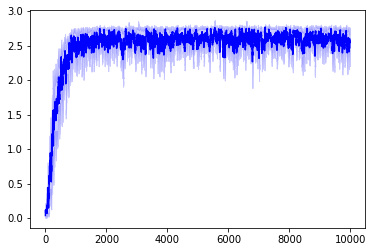

In [33]:
# Variables a guardar para reward plot
plt.plot(data_trureward_mavecr, label="DAC-ML", color='blue')

plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Rewards - all

In [35]:
reward_data = {}
ltm_data = {}
window_width = 20

for model in models:
    for ltm in ltms: 

        data_trureward = data[model+'_ltm'+ltm]['abs_tru_reward']
        data_trureward = np.asarray(data_trureward, dtype=np.float32)
        print("data_truerward_sum ", np.sum(data_trureward))

        data_ltm = data[model+'_ltm'+ltm]['LTM_full']
        data_ltm = np.asarray(data_ltm, dtype=np.float32)
        data_ltm[data_ltm == 0] = ltm #correction: LTMs that were not filled completeley should get max value

        if np.sum(data_trureward) > 0:
            if len(data_trureward[0]) > 5000: 
                data_half = np.hsplit(data_trureward, 2)
                data_trureward = data_half[0]

            mean = np.mean(data_trureward, axis=0)
            yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

            data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

            data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

            data_totalreward = np.sum(data_trureward, axis=1) 
            #data_totalreward_mean = np.mean(data_totalreward)
            #data_totalreward_std = np.std(data_totalreward)

            reward = {}
            reward['total'] = data_totalreward
            reward['mean'] = np.mean(mean)
            reward['mavecr'] = data_trureward_mavecr
            reward['mavecr_std'] = data_trureward_mavecr_std
            reward['min_val'] = data_trureward_mavecr - data_trureward_mavecr_std
            reward['max_val'] = data_trureward_mavecr + data_trureward_mavecr_std
            reward['length'] = data_trureward_mavecr_std.shape[0]

            reward_data[model+'_ltm'+ltm] = reward

            lmean = np.mean(data_ltm)
            lerr = np.std(data_ltm) / math.sqrt(len(data_ltm))

            ltm_full = {}
            ltm_full['total'] = data_ltm
            ltm_full['mean'] = lmean
            ltm_full['error'] = lerr
            ltm_full['min_val'] = lmean - lerr
            ltm_full['max_val'] = lmean + lerr

            ltm_data[model+'_ltm'+ltm] = ltm_full'''

save_plot_data(reward_data, 'reward_new', file_path)
#save_plot_data(ltm_data, 'ltm_data', file_path)

NameError: name 'ltms' is not defined

In [9]:
models = ['MFEC1388', 'MFEC2777', 'MFEC5555']

In [12]:
data['MFEC1388'].keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [14]:
reward_data = {}
ltm_data = {}
window_width = 20

for model in models:

        if model == 'MFEC1388': ltm = 1388
        if model == 'MFEC2777': ltm = 2777
        if model == 'MFEC5555': ltm = 5555
            
        data_trureward = data[model]['abs_tru_reward']
        data_trureward = np.asarray(data_trureward, dtype=np.float32)
        print("data_truerward_sum ", np.sum(data_trureward))

        data_ltm = data[model]['LTM_full']
        data_ltm = np.asarray(data_ltm, dtype=np.float32)
        data_ltm[data_ltm == 0] = ltm #correction: LTMs that were not filled completeley should get max value

        if np.sum(data_trureward) > 0:
            if len(data_trureward[0]) > 5000: 
                data_half = np.hsplit(data_trureward, 2)
                data_trureward = data_half[0]

            mean = np.mean(data_trureward, axis=0)
            yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

            data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

            data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

            data_totalreward = np.sum(data_trureward, axis=1) 
            #data_totalreward_mean = np.mean(data_totalreward)
            #data_totalreward_std = np.std(data_totalreward)

            reward = {}
            reward['total'] = data_totalreward
            reward['mean'] = np.mean(mean)
            reward['mavecr'] = data_trureward_mavecr
            reward['mavecr_std'] = data_trureward_mavecr_std
            reward['min_val'] = data_trureward_mavecr - data_trureward_mavecr_std
            reward['max_val'] = data_trureward_mavecr + data_trureward_mavecr_std
            reward['length'] = data_trureward_mavecr_std.shape[0]

            reward_data[model] = reward

            lmean = np.mean(data_ltm)
            lerr = np.std(data_ltm) / math.sqrt(len(data_ltm))

            '''ltm_full = {}
            ltm_full['total'] = data_ltm
            ltm_full['mean'] = lmean
            ltm_full['error'] = lerr
            ltm_full['min_val'] = lmean - lerr
            ltm_full['max_val'] = lmean + lerr

            ltm_data[model+'_ltm'+ltm] = ltm_full'''

save_plot_data(reward_data, 'reward_new', file_path)
#save_plot_data(ltm_data, 'ltm_data', file_path)

data_truerward_sum  4337.6997
data_truerward_sum  9201.426
data_truerward_sum  28506.424


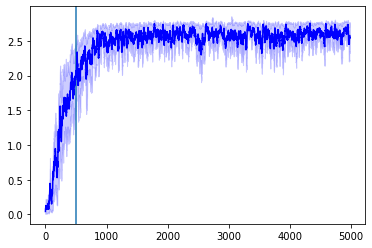

In [55]:
# Variables a guardar para reward plot
d = reward_data['SEC_ltm500']
l = ltm_data['SEC_ltm500']

plt.axvline(x=l['mean'])
plt.axvspan(l['min_val'], l['max_val'], facecolor='g', alpha=0.25)

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps - single

In [56]:
# Variables a computar para reward plot
window_width = 20
data_steps = data['SEC_ltm500']['real_steps_ts']
data_steps = np.asarray(data_steps, dtype=np.float32)

mean = np.mean(data_steps, axis=0)
yerr = np.std(data_steps, axis=0) / math.sqrt(len(data_steps))

data_steps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_steps_mavecr = (data_steps_cumsum[window_width:] - data_steps_cumsum[:-window_width]) / window_width

data_steps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_steps_mavecr_std = (data_steps_cumsum_std[window_width:] - data_steps_cumsum_std[:-window_width]) / window_width

min_val = data_steps_mavecr - data_steps_mavecr_std
max_val = data_steps_mavecr + data_steps_mavecr_std
length = data_steps_mavecr_std.shape[0]

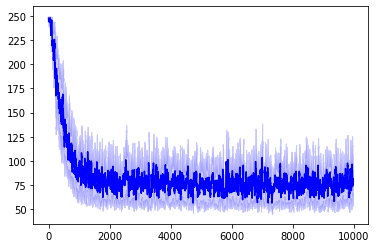

In [57]:
# Variables a guardar para reward plot
plt.plot(data_steps_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Steps - all

In [58]:
steps_data = {}
window_width = 20

for model in models:
    for ltm in ltms:
        #steps_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

        #data_trusteps = cl4_stm50_ep1000_dac['abs_tru_steps']
        data_trusteps = data[model+'_ltm'+ltm]['real_steps_ts']
        data_trusteps = np.asarray(data_trusteps, dtype=np.float32)
        print("data_trusteps_sum ", np.sum(data_trusteps))
        if np.sum(data_trusteps) > 0:
            if len(data_trusteps[0]) > 5000: 
                data_half = np.hsplit(data_trusteps, 2)
                data_trusteps = data_half[0]

            mean = np.mean(data_trusteps, axis=0)
            yerr = np.std(data_trusteps, axis=0) / math.sqrt(len(data_trusteps))

            data_trusteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_trusteps_mavecr = (data_trusteps_cumsum[window_width:] - data_trusteps_cumsum[:-window_width]) / window_width

            data_trusteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_trusteps_mavecr_std = (data_trusteps_cumsum_std[window_width:] - data_trusteps_cumsum_std[:-window_width]) / window_width

            steps = {}
            steps['mavecr'] = data_trusteps_mavecr
            steps['mavecr_std'] = data_trusteps_mavecr_std
            steps['min_val'] = data_trusteps_mavecr - data_trusteps_mavecr_std
            steps['max_val'] = data_trusteps_mavecr + data_trusteps_mavecr_std
            steps['length'] = data_trusteps_mavecr_std.shape[0]

            steps_data[model+'_ltm'+ltm] = steps

save_plot_data(steps_data, 'steps', file_path)

data_trusteps_sum  1916036.0
data_trusteps_sum  1236992.0
data_trusteps_sum  2538241.0
data_trusteps_sum  2542335.0
data_trusteps_sum  3231341.0
data_trusteps_sum  3242323.0
data_trusteps_sum  2141170.0
data_trusteps_sum  2128660.0


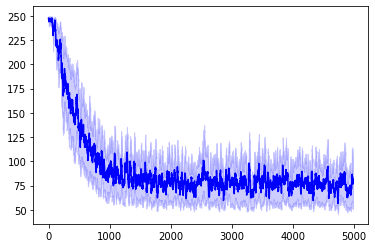

In [59]:
# Variables a guardar para reward plot
d = steps_data['SEC_ltm500']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps normalized - all

In [60]:
stepsnorm_data = {}
window_width = 20
clr = 4

for model in models:
    for ltm in ltms:
        data_trusteps = data[model+'_ltm'+ltm]['real_steps_ts']
        data_trusteps = np.asarray(data_trusteps, dtype=np.float32)
        data_trusteps = data_trusteps * clr   
        print("data_trusteps_sum ", np.sum(data_trusteps))
        if np.sum(data_trusteps) > 0:   
            if len(data_trusteps[0]) > 5000: 
                data_half = np.hsplit(data_trusteps, 2)
                data_trusteps = data_half[0]

            mean = np.mean(data_trusteps, axis=0)
            yerr = np.std(data_trusteps, axis=0) / math.sqrt(len(data_trusteps))

            data_trusteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_trusteps_mavecr = (data_trusteps_cumsum[window_width:] - data_trusteps_cumsum[:-window_width]) / window_width

            data_trusteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_trusteps_mavecr_std = (data_trusteps_cumsum_std[window_width:] - data_trusteps_cumsum_std[:-window_width]) / window_width

            steps = {}
            steps['mavecr'] = data_trusteps_mavecr
            steps['mavecr_std'] = data_trusteps_mavecr_std
            steps['min_val'] = data_trusteps_mavecr - data_trusteps_mavecr_std
            steps['max_val'] = data_trusteps_mavecr + data_trusteps_mavecr_std
            steps['length'] = data_trusteps_mavecr_std.shape[0]

            stepsnorm_data[model+'_ltm'+ltm] = steps

save_plot_data(stepsnorm_data, 'stepsnorm', file_path)

data_trusteps_sum  7664144.0
data_trusteps_sum  4947968.0
data_trusteps_sum  10152964.0
data_trusteps_sum  10169340.0
data_trusteps_sum  12925364.0
data_trusteps_sum  12969292.0
data_trusteps_sum  8564680.0
data_trusteps_sum  8514640.0


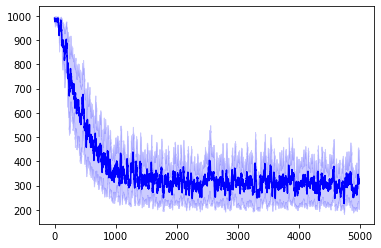

In [61]:
# Variables a guardar para reward plot
d = stepsnorm_data['SEC_ltm500']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps accumulated - single

In [62]:
# Variables a computar para reward plot
window_width = 20
data_steps_acc = data['SEC_ltm500']['acc_steps_ts']
data_steps_acc = np.asarray(data_steps_acc, dtype=np.float32)

mean = np.mean(data_steps_acc, axis=0)
yerr = np.std(data_steps_acc, axis=0) / math.sqrt(len(data_steps_acc))

data_steps_acc_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_steps_acc_mavecr = (data_steps_acc_cumsum[window_width:] - data_steps_acc_cumsum[:-window_width]) / window_width

data_steps_acc_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_steps_acc_mavecr_std = (data_steps_acc_cumsum_std[window_width:] - data_steps_acc_cumsum_std[:-window_width]) / window_width

min_val = data_steps_acc_mavecr - data_steps_acc_mavecr_std
max_val = data_steps_acc_mavecr + data_steps_acc_mavecr_std
length = data_steps_acc_mavecr_std.shape[0]


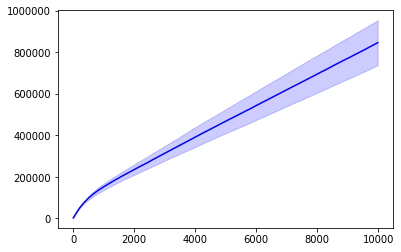

In [63]:
# Variables a guardar para reward plot
plt.plot(data_steps_acc_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Steps accumulated - all

In [64]:
stepsacc_data = {}
window_width = 20

for model in models:
    for ltm in ltms:

        data_accsteps = data[model+'_ltm'+ltm]['acc_steps_ts']
        data_accsteps = np.asarray(data_accsteps, dtype=np.float32)
        print("data_accsteps_sum ", np.sum(data_accsteps))

        if np.sum(data_accsteps) > 0:
            if len(data_accsteps[0]) > 5000: 
                data_half = np.hsplit(data_accsteps, 2)
                data_accsteps = data_half[0]

            mean = np.mean(data_accsteps, axis=0)
            yerr = np.std(data_accsteps, axis=0) / math.sqrt(len(data_accsteps))

            data_accsteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_accsteps_mavecr = (data_accsteps_cumsum[window_width:] - data_accsteps_cumsum[:-window_width]) / window_width

            data_accsteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_accsteps_mavecr_std = (data_accsteps_cumsum_std[window_width:] - data_accsteps_cumsum_std[:-window_width]) / window_width

            totalsteps = []
            for d in data_accsteps: 
                #print(d[-1])
                totalsteps.append(d[-1])

            steps = {}
            steps['total'] = totalsteps
            steps['mavecr'] = data_accsteps_mavecr
            steps['mavecr_std'] = data_accsteps_mavecr_std
            steps['min_val'] = data_accsteps_mavecr - data_accsteps_mavecr_std
            steps['max_val'] = data_accsteps_mavecr + data_accsteps_mavecr_std
            steps['length'] = data_accsteps_mavecr_std.shape[0]

            stepsacc_data[model+'_ltm'+ltm] = steps

save_plot_data(stepsacc_data, 'stepsacc', file_path)

data_accsteps_sum  5090842600.0
data_accsteps_sum  3456101400.0
data_accsteps_sum  13853341000.0
data_accsteps_sum  14203955000.0
data_accsteps_sum  8212174000.0
data_accsteps_sum  8355335700.0
data_accsteps_sum  5959227000.0
data_accsteps_sum  5816995000.0


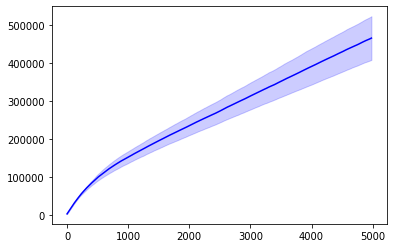

In [65]:
# Variables a guardar para reward plot
d = stepsacc_data['SEC_ltm500']
plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Entropy - single

In [66]:
# Variables a computar para reward plot
window_width = 20
data_truentropy = data['SEC_ltm500']['mean_entropy']
data_truentropy = np.asarray(data_truentropy, dtype=np.float32)

mean = np.mean(data_truentropy, axis=0)
yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

min_val = data_truentropy_mavecr - data_truentropy_mavecr_std
max_val = data_truentropy_mavecr + data_truentropy_mavecr_std
length = data_truentropy_mavecr_std.shape[0]

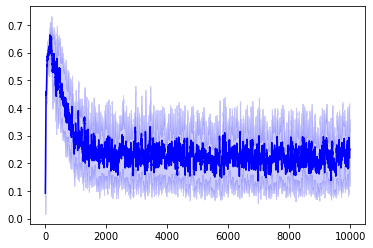

In [67]:
# Variables a guardar para reward plot
plt.plot(data_truentropy_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Entropy - all

In [26]:
models = ['MFEC1388', 'MFEC2777', 'MFEC5555']

In [29]:
entropy_data = {}
window_width = 20

for model in models:

    #entropy_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

    #data_truentropy = cl4_stm50_ep1000_dac['abs_tru_entropy']
    data_truentropy = data[model]['mean_entropy']
    data_truentropy = np.asarray(data_truentropy, dtype=np.float32)
    print("data_truentropy_sum ", np.sum(data_truentropy))
    #if np.sum(data_truentropy) > 0:                       
    if len(data_truentropy[0]) > 5000: 
        data_half = np.hsplit(data_truentropy, 2)
        data_truentropy = data_half[0]

    mean = np.mean(data_truentropy, axis=0)
    yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

    data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
    data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

    data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
    data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

    entropy = {}
    entropy['mavecr'] = data_truentropy_mavecr
    entropy['mavecr_std'] = data_truentropy_mavecr_std
    entropy['min_val'] = data_truentropy_mavecr - data_truentropy_mavecr_std
    entropy['max_val'] = data_truentropy_mavecr + data_truentropy_mavecr_std
    entropy['length'] = data_truentropy_mavecr_std.shape[0]

    entropy_data[model] = entropy

save_plot_data(entropy_data, 'entropy', file_path)

data_truentropy_sum  -49188064.0
data_truentropy_sum  -41208910.0
data_truentropy_sum  -41825480.0


In [30]:
entropy_data

{'MFEC1388': {'mavecr': array([-790.8037, -817.4577, -817.7118, ..., -821.2625, -821.2375,
         -821.2375], dtype=float32),
  'mavecr_std': array([0.58067834, 0.6335839 , 0.6069598 , ..., 3.4149413 , 3.4122558 ,
         3.4083984 ], dtype=float32),
  'min_val': array([-791.3844, -818.0913, -818.3187, ..., -824.6774, -824.6497,
         -824.6459], dtype=float32),
  'max_val': array([-790.223  , -816.8241 , -817.10486, ..., -817.8476 , -817.82526,
         -817.8291 ], dtype=float32),
  'length': 4981},
 'MFEC2777': {'mavecr': array([-792.3947 , -819.21594, -819.5952 , ..., -827.275  , -827.2    ,
         -827.125  ], dtype=float32),
  'mavecr_std': array([1.2109061, 1.3252383, 1.3393224, ..., 5.432031 , 5.4249024,
         5.4330077], dtype=float32),
  'min_val': array([-793.6056 , -820.5412 , -820.9345 , ..., -832.70703, -832.62494,
         -832.558  ], dtype=float32),
  'max_val': array([-791.18384, -817.8907 , -818.2559 , ..., -821.843  , -821.7751 ,
         -821.692  ], dty

In [ ]:
entropy_data = {}
window_width = 20

for model in models:
    #entropy_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

    #data_truentropy = cl4_stm50_ep1000_dac['abs_tru_entropy']
    data_truentropy = data[model]['mean_entropy']
    data_truentropy = np.asarray(data_truentropy, dtype=np.float32)
    print("data_truentropy_sum ", np.sum(data_truentropy))
    if np.sum(data_truentropy) > 0:                       
        if len(data_truentropy[0]) > 5000: 
            data_half = np.hsplit(data_truentropy, 2)
            data_truentropy = data_half[0]

        mean = np.mean(data_truentropy, axis=0)
        yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

        data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

        data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

        entropy = {}
        entropy['mavecr'] = data_truentropy_mavecr
        entropy['mavecr_std'] = data_truentropy_mavecr_std
        entropy['min_val'] = data_truentropy_mavecr - data_truentropy_mavecr_std
        entropy['max_val'] = data_truentropy_mavecr + data_truentropy_mavecr_std
        entropy['length'] = data_truentropy_mavecr_std.shape[0]

        entropy_data[model] = entropy

save_plot_data(entropy_data, 'entropy', file_path)

In [ ]:
entropy_data = {}
window_width = 20

for model in models:
    for ltm in ltms:
        #entropy_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

        #data_truentropy = cl4_stm50_ep1000_dac['abs_tru_entropy']
        data_truentropy = data[model+'_ltm'+ltm]['mean_entropy']
        data_truentropy = np.asarray(data_truentropy, dtype=np.float32)
        print("data_truentropy_sum ", np.sum(data_truentropy))
        if np.sum(data_truentropy) > 0:                       
            if len(data_truentropy[0]) > 5000: 
                data_half = np.hsplit(data_truentropy, 2)
                data_truentropy = data_half[0]

            mean = np.mean(data_truentropy, axis=0)
            yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

            data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

            data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

            entropy = {}
            entropy['mavecr'] = data_truentropy_mavecr
            entropy['mavecr_std'] = data_truentropy_mavecr_std
            entropy['min_val'] = data_truentropy_mavecr - data_truentropy_mavecr_std
            entropy['max_val'] = data_truentropy_mavecr + data_truentropy_mavecr_std
            entropy['length'] = data_truentropy_mavecr_std.shape[0]

            entropy_data[model+'_ltm'+ltm] = entropy

save_plot_data(entropy_data, 'entropy', file_path)

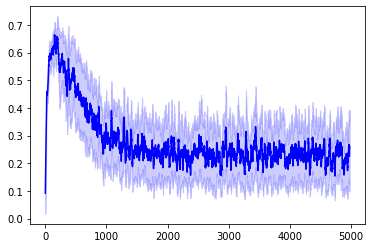

In [69]:
# Variables a guardar para entropy plot
d = entropy_data['SEC_ltm500']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Layer activity - single

In [70]:
# Variables a computar para reward plot
window_width = 20
data_contextact = data['SEC_ltm500']['contextual_relact']
data_contextact = np.asarray(data_contextact, dtype=np.float32)

mean = np.mean(data_contextact, axis=0)
yerr = np.std(data_contextact, axis=0) / math.sqrt(len(data_contextact))

data_contextact_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_contextact_mavecr = (data_contextact_cumsum[window_width:] - data_contextact_cumsum[:-window_width]) / window_width

data_contextact_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_contextact_mavecr_std = (data_contextact_cumsum_std[window_width:] - data_contextact_cumsum_std[:-window_width]) / window_width

min_val = data_contextact_mavecr - data_contextact_mavecr_std
max_val = data_contextact_mavecr + data_contextact_mavecr_std
length = data_contextact_mavecr_std.shape[0]

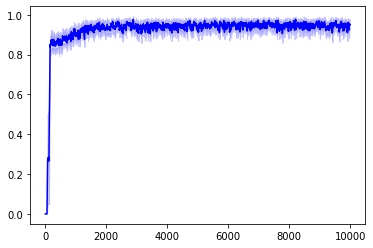

In [71]:
# Variables a guardar para reward plot
plt.plot(data_contextact_mavecr, label="Reactive", color='blue')

plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Layer activity - all

In [72]:
contextact_data = {}
window_width = 20


for model in models:
    for ltm in ltms:
        data_contextact = data[model+'_ltm'+ltm]['contextual_relact']
        data_contextact = np.asarray(data_contextact, dtype=np.float32)
        print("data_contextact_sum ", np.sum(data_contextact))
        if np.sum(data_contextact) > 0:                       
            if len(data_contextact[0]) > 5000: 
                data_half = np.hsplit(data_contextact, 2)
                data_contextact = data_half[0]

            mean = np.mean(data_contextact, axis=0)
            yerr = np.std(data_contextact, axis=0) / math.sqrt(len(data_contextact))

            data_contextact_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
            data_contextact_mavecr = (data_contextact_cumsum[window_width:] - data_contextact_cumsum[:-window_width]) / window_width

            data_contextact_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
            data_contextact_mavecr_std = (data_contextact_cumsum_std[window_width:] - data_contextact_cumsum_std[:-window_width]) / window_width

            contextact = {}
            contextact['mavecr'] = data_contextact_mavecr
            contextact['mavecr_std'] = data_contextact_mavecr_std
            contextact['min_val'] = data_contextact_mavecr - data_contextact_mavecr_std
            contextact['max_val'] = data_contextact_mavecr + data_contextact_mavecr_std
            contextact['length'] = data_contextact_mavecr_std.shape[0]

            contextact_data[model+'_ltm'+ltm] = contextact

save_plot_data(contextact_data, 'contextact', file_path)

data_contextact_sum  13388.72
data_contextact_sum  13914.703
data_contextact_sum  27708.217
data_contextact_sum  27794.3
data_contextact_sum  13286.877
data_contextact_sum  13266.439
data_contextact_sum  13325.658
data_contextact_sum  13250.661


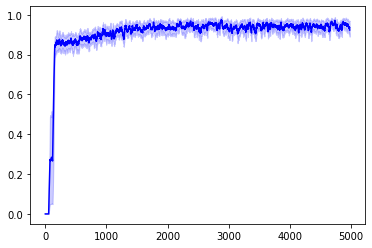

In [73]:
# Variables a guardar para entropy plot
d = contextact_data['SEC_ltm500']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)